In [1]:
####################################################################################################
# CR.Screening.AOD_WV_Precip_Tau.ipynb
# Karl Lapo
####################################################################################################
# Aggregating data according to AOD, WV, Precip, and Tau. Figures for CalRad Paper
####################################################################################################

# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## Import statements
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xray
import kray # Custom functions for manipulating xray structures
from scipy import interpolate as interp
from scipy.stats.stats import pearsonr
from scipy import stats
import pylab

# OS interaction
import sys, pickle, os

# import subplots function for plotting
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Solargeometry
import solargeo

#### Directory Lists
# Unix
if 'linux' in sys.platform:
    dir_pre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dir_pre = '/Users/karllapo/gdrive/'

dir_data = dir_pre+'SnowHydrology/proj/CloudClimatology/data'
dir_print = dir_pre+'SnowHydrology/proj/CloudClimatology/Graphics'

# List of sub-directory names for each data set
dir_NLDAS = '/NLDAS'
dir_SYN = '/CERES_SYN'
dir_grobs = '/GroundObs'
dir_VIC = '/VIC_MTCLIM'
dir_WRF = '/WRF'
dir_AN = '/aeronet'

# Directory for basemap pickle files
dir_bmap = dir_pre+'SnowHydrology/proj/CloudClimatology/data/basemap'

/home/lapok/anaconda2/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
/home/lapok/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
####################################################################################################
# Load Data
####################################################################################################
os.chdir(dir_data)
grobs = xray.open_dataset('grobs.daily.nc')
grobs_diff = xray.open_dataset('grobs_bias.daily.nc')
anom_day = xray.open_dataset('tau_anom.daily.nc')
anom_mon = xray.open_dataset('tau_anom.monthly.nc')
tau = xray.open_dataset('tau.daily.nc')

## Names
pr_names = ['mtclim','nldas','syn','wrf']
num_products = np.size(pr_names)
grouping = ['north cv','south cv','west of crest','foothills','east of crest']

## Transmissivity
tau_products = xray.Dataset()
full_pr_names = ['mtclim','nldas','syn','wrf','grobs']
for pr in full_pr_names:
    tau_products[pr] = grobs[pr]/(np.sin(grobs.el*np.pi/180)*1365)

In [3]:
print(tau_products)

<xarray.Dataset>
Dimensions:    (station: 70, time: 5753)
Coordinates:
    network    (station) |S9 'CIMIS_IPM' 'CIMIS_IPM' 'CIMIS_IPM' 'CDWR' ...
    longitude  (station) float64 -119.5 -118.8 -121.1 -118.3 -118.4 -120.0 ...
  * station    (station) |S19 'Alpaugh' 'ARVIN' 'Auburn' 'bee' 'BISHOP' ...
    elev       (station) float64 64.0 152.0 285.0 2.768e+03 1.271e+03 215.0 ...
    latitude   (station) float64 35.87 35.2 38.88 37.53 37.35 35.65 37.93 ...
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 ...
    Grouping   (station) |S13 'south cv' 'foothills' 'foothills' ...
Data variables:
    mtclim     (time, station) float64 0.617 0.3711 0.5815 0.667 0.6583 ...
    nldas      (time, station) float64 nan nan nan nan nan nan nan nan nan ...
    syn        (time, station) float64 nan nan nan nan nan nan nan nan nan ...
    wrf        (time, station) float64 nan nan nan nan nan nan nan nan nan ...
    grobs      (time, station) float64 nan nan nan nan nan nan nan n

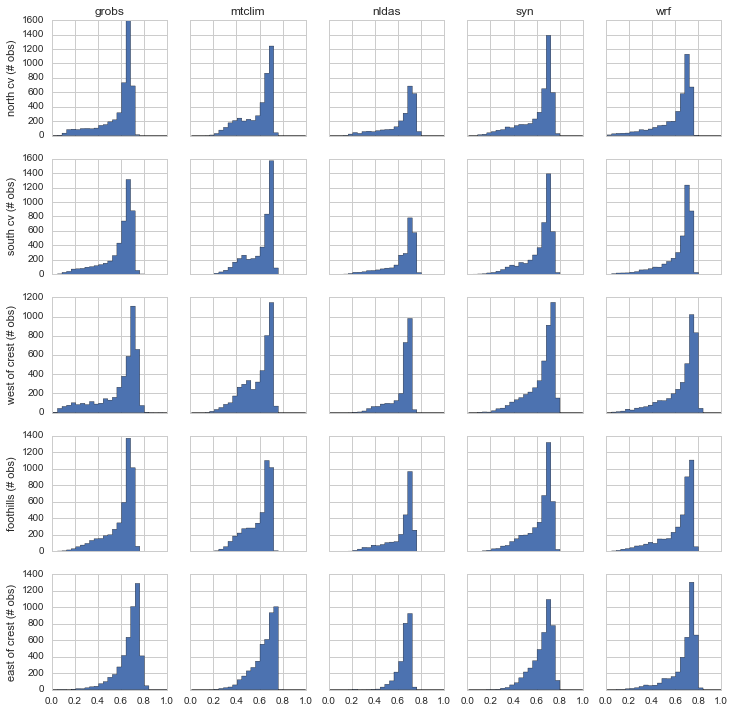

In [4]:
## Tau histogram -- Obs
# nbins = 25
# fig,axes = plt.subplots(5,1,sharex='col',figsize=(5,8))
# for n,gr in enumerate(grouping):
#     ax = axes[n]

#     tau_for_hist = tau.to_array().swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].mean('Grouping').values
#     tau_for_hist = np.ma.masked_where(np.isnan(tau_for_hist),tau_for_hist)
#     tau_for_hist = np.ma.masked_where(np.isinf(tau_for_hist),tau_for_hist)

#     n, bins, patches = ax.hist(tau_for_hist[0,:],range=(.01,1),bins=nbins)
#     ax.set_title(gr)
    
## Tau histogram -- Products
fig,axes = plt.subplots(5,5,sharex='col',sharey='row',figsize=(12,12))
nbins = 25
pr_names_plot = ['grobs','mtclim','nldas','syn','wrf']
for n_pr,pr in enumerate(pr_names_plot):
    for n_gr,gr in enumerate(grouping):
        ax = axes[n_gr,n_pr]

        tau_for_hist = tau_products[pr].swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].mean('Grouping')
        tau_for_hist = np.ma.masked_where(np.isnan(tau_for_hist),tau_for_hist)
        tau_for_hist = np.ma.masked_where(np.isinf(tau_for_hist),tau_for_hist)

        n, bins, patches = ax.hist(tau_for_hist,range=(.01,1),bins=nbins, histtype='stepfilled')
        if n_gr == 0:
            ax.set_title(pr)
        if n_pr == 0:
            ax.set_ylabel(gr+' (# obs)')

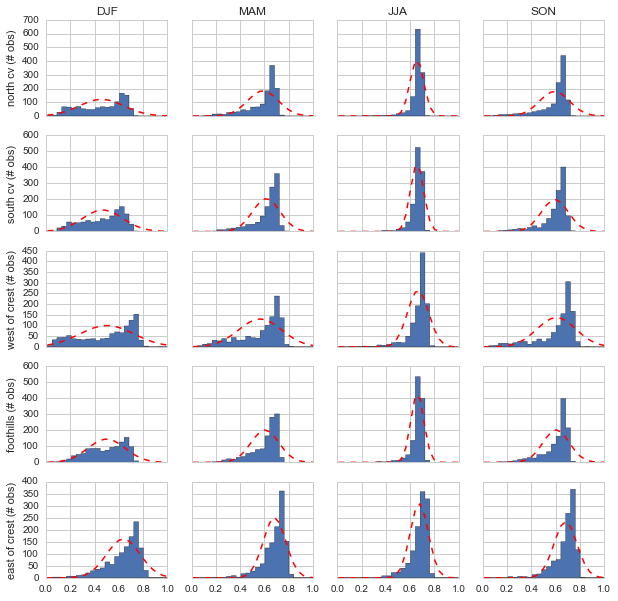

In [5]:
## Tau histogram by season
seasons = ['DJF','MAM','JJA','SON']
fig,axes = plt.subplots(5,4,sharex='col',sharey='row',figsize=(10,10))
y = np.empty((5,4,25+1))
for n_s,s in enumerate(seasons):
    for n_gr,gr in enumerate(grouping):
        ax = axes[n_gr,n_s]

        tau_for_hist = tau.to_array().swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].mean('Grouping')
        tau_for_hist = tau_for_hist.sel(time=(tau_for_hist['time.season'] == s))
        tau_for_hist = np.ma.masked_where(np.isnan(tau_for_hist),tau_for_hist)
        tau_for_hist = np.ma.masked_where(np.isinf(tau_for_hist),tau_for_hist)

        n, bins, patches = ax.hist(tau_for_hist[0,:],range=(.01,1),bins=25, histtype='stepfilled')
        # add a line showing the expected distribution
        dx = bins[1] - bins[0]
        scale = tau_for_hist.size*dx
        mu = tau_for_hist.mean()
        sigma = tau_for_hist.std()
        y[n_gr,n_s,:] = pylab.normpdf( bins, mu, sigma)
        ax.plot(bins, np.squeeze(y[n_gr,n_s,:])*scale, 'r--', linewidth=1.5)
        
        if n_gr == 0:
            ax.set_title(s)
        if n_s == 0:
            ax.set_ylabel(gr+' (# obs)')

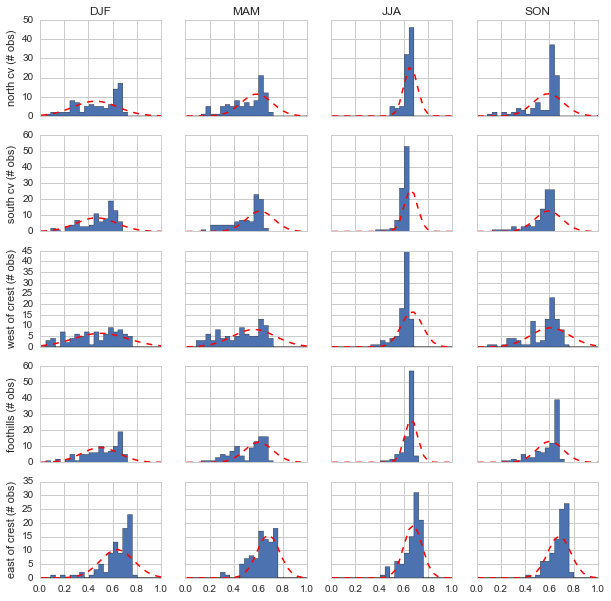

In [100]:
#### 2006
## Tau histogram by season
seasons = ['DJF','MAM','JJA','SON']
fig,axes = plt.subplots(5,4,sharex='col',sharey='row',figsize=(10,10))

for n_s,s in enumerate(seasons):
    for n_gr,gr in enumerate(grouping):
        ax = axes[n_gr,n_s]

        tau_for_hist = tau.to_array().sel(time=(tau['time.year']==2006))
        tau_for_hist = tau_for_hist.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].mean('Grouping')
        tau_for_hist = tau_for_hist.sel(time=(tau_for_hist['time.season'] == s))
        tau_for_hist = np.ma.masked_where(np.isnan(tau_for_hist),tau_for_hist)
        tau_for_hist = np.ma.masked_where(np.isinf(tau_for_hist),tau_for_hist)

        n, bins, patches = ax.hist(tau_for_hist[0,:],range=(.01,1),bins=25, histtype='stepfilled')
        
        dx = bins[1] - bins[0]
        scale = tau_for_hist.size*dx
        ax.plot(bins, np.squeeze(y[n_gr,n_s,:])*scale, 'r--', linewidth=1.5)
        
        if n_gr == 0:
            ax.set_title(s)
        if n_s == 0:
            ax.set_ylabel(gr+' (# obs)')



# fig,axes = plt.subplots(1,5,sharex='col',sharey='row',figsize=(12,12))
# for n_gr,gr in enumerate(grouping):
#     ax = axes[n_gr,n_d]

#     tau_for_hist = tau.to_array().swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].mean('Grouping')
#     tau_for_hist = tau_for_hist.sel(time=(tau_for_hist['time.month'] == mon))
#     tau_for_hist = np.ma.masked_where(np.isnan(tau_for_hist),tau_for_hist)
#     tau_for_hist = np.ma.masked_where(np.isinf(tau_for_hist),tau_for_hist)

#     n, bins, patches = ax.hist(tau_for_hist[0,:],range=(.01,1),bins=50)
#     if n_gr == 0:
#         ax.set_title(str(d))
#     if n_s == 0:
#         ax.set_ylabel(gr+' (# obs)')

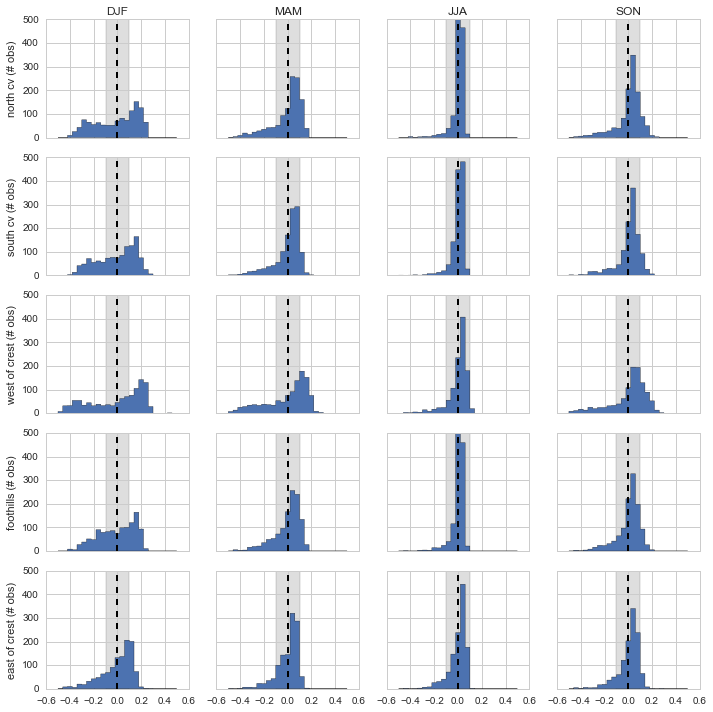

In [10]:
seasons = ['DJF','MAM','JJA','SON']
os.chdir(dir_data)
anom_day = xray.open_dataset('tau_anom.daily.nc')
fig,axes = plt.subplots(5,4,sharex='col',sharey='row',figsize=(10,10))

for n_s,s in enumerate(seasons):
    for n_gr,gr in enumerate(grouping):
        ax = axes[n_gr,n_s]

        tau_for_hist = anom_day.to_array().loc[{'Grouping':gr}]
        tau_for_hist = tau_for_hist.sel(time=(tau_for_hist['time.season'] == s))
        tau_for_hist = np.ma.masked_where(np.isnan(tau_for_hist),tau_for_hist)
        tau_for_hist = np.ma.masked_where(np.isinf(tau_for_hist),tau_for_hist)

        ax.plot(np.array((0,0)),np.array((0,1000)),'--',color='k',lw=2,zorder=1)
        ax.fill_between(np.array((-.1,.1)),np.array((1000,1000)),facecolor='.75',alpha=.5,zorder=0)
        n, bins, patches = ax.hist(tau_for_hist[0,:],range=(-.5,.5),bins=25, histtype='stepfilled')
        ax.set_ylim(0,500)

        if n_gr == 0:
            ax.set_title(s)
        if n_s == 0:
            ax.set_ylabel(gr+' (# obs)')
            
os.chdir(dir_print)
fig.tight_layout()
fig.savefig('TauAnomHistogram.pdf')

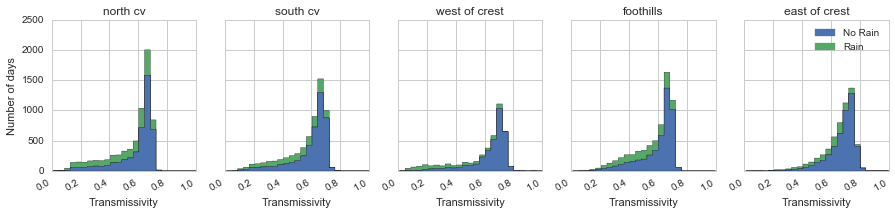

In [61]:
## Tau histogram by precip vs no precip
import matplotlib.patches as mpatches
fig,axes = plt.subplots(1,5,sharey='row',figsize=(15,3))

for n_gr,gr in enumerate(grouping):
    ax = axes[n_gr]

    tau_for_hist = tau.to_array().swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].mean('Grouping')
    tau_for_hist_dry = tau_for_hist.where(grobs.precip == 0)
    tau_for_hist_wet = tau_for_hist.where(grobs.precip > 0)

    tau_for_hist_dry = tau_for_hist_dry.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].mean('Grouping')
    tau_for_hist_wet = tau_for_hist_wet.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].mean('Grouping')

    n, bins, patchesDry = ax.hist([tau_for_hist_dry[0,:],tau_for_hist_wet[0,:]],\
                                range=(.01,1),bins=25, stacked=True, histtype='stepfilled')

    ax.set_title(gr)
    ax.set_xlabel('Transmissivity')
    if n_gr == 0:
        ax.set_ylabel('Number of days')
    if n_gr == 4:
        patchWet = mpatches.Patch(color=patchesWet[0].get_facecolor(),label='Rain')
        patchDry = mpatches.Patch(color=patchesDry[0][0].get_facecolor(),label='No Rain')
        ax.legend(handles=[patchDry,patchWet])

fig.autofmt_xdate()

AttributeError: 'list' object has no attribute 'get_facecolor'

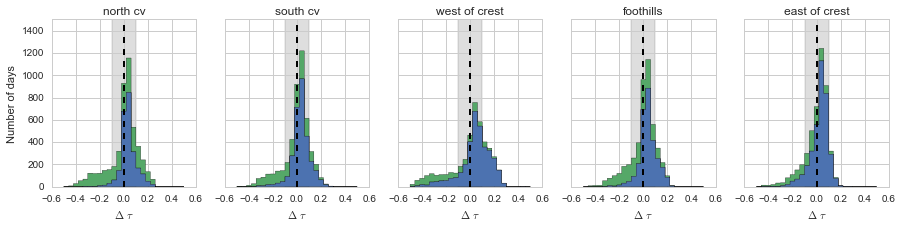

In [62]:
os.chdir(dir_data)
anom_day = xray.open_dataset('tau_anom.daily.nc')
fig,axes = plt.subplots(1,5,sharey='row',figsize=(15,3))

for n_gr,gr in enumerate(grouping):
    ax = axes[n_gr]

    tau_for_hist = anom_day.anom_mean.loc[{'Grouping':gr}]
    tau_for_hist_dry = tau_for_hist.where(anom_day.loc[{'Grouping':gr}].precip == 0)
    tau_for_hist_wet = tau_for_hist.where(anom_day.loc[{'Grouping':gr}].precip > 0)


    ax.plot(np.array((0,0)),np.array((0,2000)),'--',color='k',lw=2,zorder=1)
    ax.fill_between(np.array((-.1,.1)),np.array((2000,2000)),facecolor='.75',alpha=.5,zorder=0)

    n, bins, patchesDry = ax.hist([tau_for_hist_dry,tau_for_hist_wet],\
                                range=(-.5,.5),bins=25, stacked=True, histtype='stepfilled')

    ax.set_ylim(0,1500)

    ax.set_title(gr)
    ax.set_xlabel('$\Delta$ $\\tau$')
    if n_gr == 0:
        ax.set_ylabel('Number of days')
    if n_gr == 4:
        patchWet = mpatches.Patch(color=patchesWet[0].get_facecolor(),label='Rain')
        patchDry = mpatches.Patch(color=patchesDry[0].get_facecolor(),label='No Rain')
        ax.legend(handles=[patchDry,patchWet])
        
fig.autofmt_xdate()

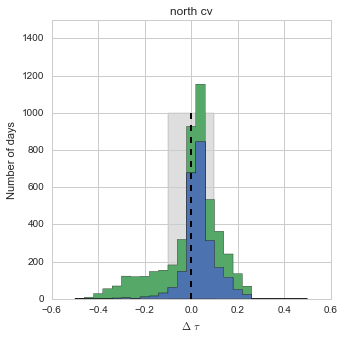

In [51]:
fig,ax = plt.subplots(1,1,sharey='row',figsize=(5,5))

tau_for_hist = anom_day.anom_mean.loc[{'Grouping':gr}]
tau_for_hist_dry = tau_for_hist.where(anom_day.loc[{'Grouping':gr}].precip == 0)
tau_for_hist_wet = tau_for_hist.where(anom_day.loc[{'Grouping':gr}].precip > 0)


ax.plot(np.array((0,0)),np.array((0,2000)),'--',color='k',lw=2,zorder=1)
ax.fill_between(np.array((-.1,.1)),np.array((2000,2000)),facecolor='.75',alpha=.5,zorder=0)

n, bins, patchesDry = ax.hist([tau_for_hist_dry,tau_for_hist_wet],\
                            range=(-.5,.5),bins=25, stacked=True, histtype='stepfilled')

ax.set_ylim(0,1500)

ax.set_title(gr)
ax.set_xlabel('$\Delta$ $\\tau$')
if n_gr == 0:
    ax.set_ylabel('Number of days')
if n_gr == 4:
    patchWet = mpatches.Patch(color=patchesWet[0].get_facecolor(),label='Rain')
    patchDry = mpatches.Patch(color=patchesDry[0].get_facecolor(),label='No Rain')
    ax.legend(handles=[patchDry,patchWet])